# Agent-based implementation of a simple spatial epidemics model

Here, I modelled the logistic growth (Verhulst) of a disease. Because of the limited and constant number of agents with two possible conditions, it is equivalent to the Bass (innovation) diffusion model (susceptibles as possible "adopters" of an infect). At time step 0, one agent is infected. At time step 1 the neighbouring agents of the infectious one within a certain critical distance are infected too and so on.
Although their Boolean agents-like two possible states (susceptible and infected), due to the agents random spatial mobility (Brownian motion), they are in fact Brownian agents.

The susceptible agents within an arbitrarily predefined critical distance radius to the infectious agent will be infected and as a consequence become infectious themselves. In this simple case; infected = infectious.
The transmission rate ($\beta$) of the Ebola system dynamics model (https://github.com/Staphylosaurus/Ebola-outbreak-in-Nigeria-2014/blob/master/ebola_python.ipynb) is the equivalent to the *critical_distance* in this ABM. It could be implemented exponentially decreasing in a more advanced model (alternative: control the distance of the susceptibles to the infectious).
There are no positional restrictions implemented (no prevention of collision, no limitation of movement within the frame).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd # for R-like dataframes
from scipy.spatial import distance_matrix
from IPython.display import *
import seaborn as sns

In [3]:
nAgents = 100
nXY = 100 # Area
nUpdates = 100*2 # time steps or frames in animation
critical_distance = 5

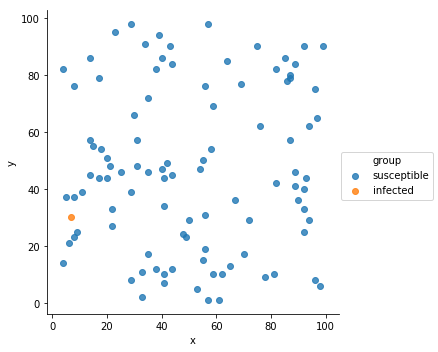

In [4]:
dat = pd.DataFrame(data=np.random.randint(low=0, high=nXY, size=(nAgents, 2)), columns=["x", "y"])
dat = dat.join(pd.DataFrame(data=np.repeat("susceptible", len(dat)), columns=['group']))
dat.loc[np.random.randint(low=0, high=100), 'group'] = "infected"

sns.lmplot('x', 'y', data=dat, hue='group', fit_reg=False) # Seaborn

In [5]:
x_trajectory = np.random.normal(loc=0, scale=1, size=(nAgents, nUpdates))
y_trajectory = np.random.normal(loc=0, scale=1, size=(nAgents, nUpdates))

Randomly were defined:
- *nAgents* agents in a 2D environment (area = *nXY*$^{2}$)
- one agent is infectious, the others are susceptible
- the Brownian motion of the agents on the x and y axis in *nUpdates* time steps

In [6]:
state = pd.DataFrame({'0': dat['group']})

for i in range(nUpdates):
    if i > 0:
        x = dat['x'] + np.sum(x_trajectory[:, 0:i], axis=1)
        y = dat['y'] + np.sum(y_trajectory[:, 0:i], axis=1)
        coor = pd.DataFrame([x,y]).T
        matrix = pd.DataFrame(distance_matrix(coor, coor)) # index=dat.index, columns=dat.index
        infekt = matrix[matrix[state.iloc[:, -1] == "infected"].index].min(axis=1) < critical_distance
        
        state_t = pd.DataFrame({i: state.iloc[:, -1]})
        state_t[infekt] = "infected"
        state = state.join(state_t)

Text(0,0.5,'people')

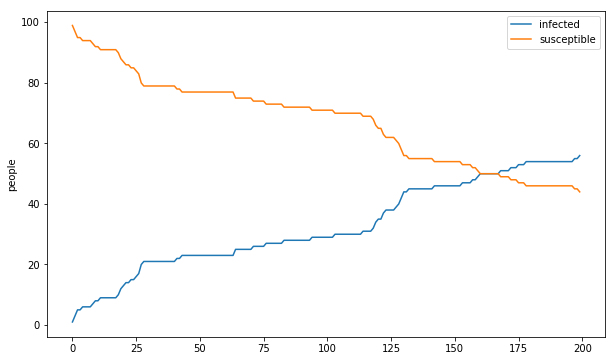

In [7]:
was, zahl = np.unique(state.iloc[:,0], return_counts=True)
zahl = pd.DataFrame({0: zahl})

for i in range(nUpdates):
    if i > 0:
        was, zahl2 = np.unique(state.iloc[:,i], return_counts=True)
        zahl = zahl.join(pd.DataFrame({i: zahl2}))

zahl = zahl.T
zahl.columns = was

plt.rcParams['figure.figsize'] = 10, 6
zahl.plot(x=zahl.index).set_ylabel("people")#.set_xlabel("t")

The data frame *state* captures the state (susceptible or infected) of every agent at every time step. Based on that, it is possible to plot the empirical stock level (the "system dynamics"). This plot (1) anticipates what we can observe in the animation in more detail and (2) allows a comparison of a highly randomized agent-based model run with a fully deterministic system dynamics model.

The increase of the critical distance as well as the increase of the number of agents results in a speeded-up convergence of the model.

# Animation

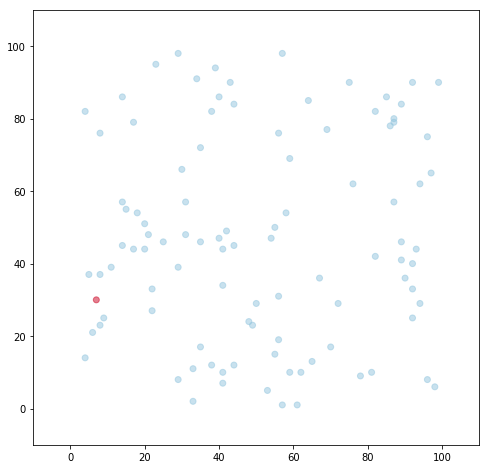

In [8]:
def farbgebung(i):
    col = np.repeat("#92c5de", len(i)) # susceptible
    col[i == 'infected'] = "#ca0020"
    return col

fig, ax = plt.subplots(figsize=(8, 8))
ax.set(xlim=(0-10, nXY+10), ylim=(0-10, nXY+10))
scat = ax.scatter(dat['x'], dat['y'], color=farbgebung(dat['group']), alpha=0.5)

def animate(frame):
    x = dat['x'] + np.sum(x_trajectory[:, 0:frame], axis=1)
    y = dat['y'] + np.sum(y_trajectory[:, 0:frame], axis=1)
    col = farbgebung(state.iloc[:,frame])
    
    scat.set_offsets(np.c_[x, y])
    scat.set_edgecolors(col)
    scat.set_facecolors(col)
    
# The below plot is useless and I would like to prevent it from being displayed

In [10]:
anim = FuncAnimation(fig, animate, frames=nUpdates)
# anim.save('outbreak.mp4', codec='h264')
HTML(anim.to_html5_video())

# Discussion

In every run of the ABM (provided: reassignment of the random variables), we observe a rather different behavior over time. This is the most obvious difference between agent-based and system dynamic modelling.
Based on the model properties, we would expect an S-shaped development of the stocks. In the beginning, just a few infectious agents infect the many susceptibles slowly (logistic growth). As the infectious group grow, they accelerate their pace of infection. Later, when just a few susceptibles are left, then the infections per unit of time decrease again. This behavior, however, is not always visible. Sometimes it is more a linear or even a reverse S-shaped interrelation. Often the first third is approximatively linear, while the second and third third show the expected logistic growth curve. Possibly, such irregularities have to do with the randomly assigned starting point of the infection and wether or not point clusters or spatial distribution holes occur. However, on average over countless repetitions, the growth curve would be a logistic one.

System Dynamics is equation-based and thus fully deterministic and focuses on nonlinear feedback affecting stocks of homogenous units. Further, SD results in continuous rather than discrete values and hence might not readily be suitable for some real world problems especially with small unit numbers.
ABM on the other hand models the emergence of collective dynamics based on individual and heterogeneous agents in a highly randomized manner (different behavior in every model run).
In contrast to SD, ABMs provide individual level details additionally to aggregated ones at the same time.
Based on modelled individual behavior with a limited set of simple rules, unexpected aggregate phenomena can emerge.